## 데이타 확인

2121728/2110848 [==============================] - 0s 0us/step
훈련 샘플의 수: 8982
테스트 샘플의 수: 2246
클래스의 수 : 46
훈련용 뉴스의 최대 길이 :2376
훈련용 뉴스의 평균 길이 :145.5398574927633


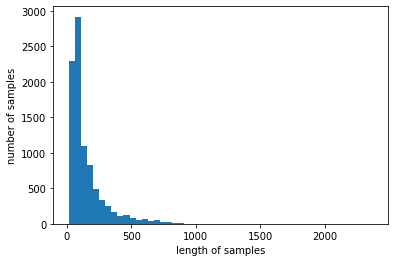

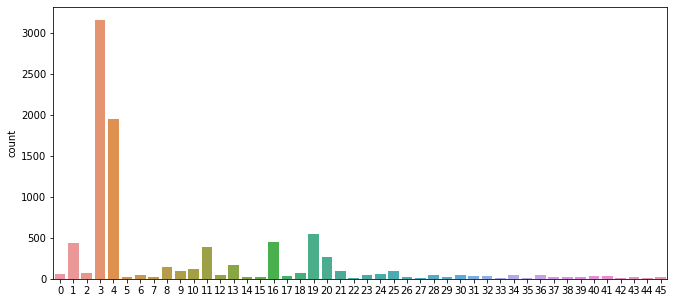

각 클래스 빈도수:
[[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
    14   15   16   17   18   19   20   21   22   23   24   25   26   27
    28   29   30   31   32   33   34   35   36   37   38   39   40   41
    42   43   44   45]
 [  55  432   74 3159 1949   17   48   16  139  101  124  390   49  172
    26   20  444   39   66  549  269  100   15   41   62   92   24   15
    48   19   45   39   32   11   50   10   49   19   19   24   36   30
    13   21   12   18]]


In [1]:
from tensorflow.keras.datasets import reuters
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=10000, test_split=0.2)

print('훈련 샘플의 수: {}'.format(len(x_train)))
print('테스트 샘플의 수: {}'.format(len(x_test)))

num_classes = max(y_train) + 1
print('클래스의 수 : {}'.format(num_classes))

print('훈련용 뉴스의 최대 길이 :{}'.format(max(len(l) for l in x_train)))
print('훈련용 뉴스의 평균 길이 :{}'.format(sum(map(len, x_train))/len(x_train)))

plt.hist([len(s) for s in x_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(11,5)
sns.countplot(x=y_train)
plt.show()

unique_elements, counts_elements = np.unique(y_train, return_counts=True)
print("각 클래스 빈도수:")
print(np.asarray((unique_elements, counts_elements)))

## Vocab Size별 데이타 로딩 및 단어장 구성

In [2]:
# word index
word_index = reuters.get_word_index(path="reuters_word_index.json")

#<pad>, <sos>, <unk>
index_to_word = { index+3 : word for word, index in word_index.items() }
# index_to_word에 숫자 0은 <pad>, 숫자 1은 <sos>, 숫자 2는 <unk>를 넣어줍니다.
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
    index_to_word[index]=token

print(len(word_index))

565248/550378 [==============================] - 0s 0us/step
30979


## 딥러닝

In [3]:
import numpy as np

(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=None, test_split=0.2)


def decode_to_text( text ) :
    decoded_text = []
    for i in range(len( text)):
        t = ' '.join([index_to_word[index] for index in text[i]])
        decoded_text.append(t)
    
    return decoded_text
      
decoded_train = decode_to_text( x_train )
decoded_test = decode_to_text( x_test )


# 시퀀스를 이진 벡터로 변환 (Bag of Words 방식)
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        # ✅ dimension보다 작은 인덱스만 포함
        filtered_indices = [idx for idx in sequence if idx < dimension]
        results[i, filtered_indices] = 1.0
    return results

In [47]:
from tensorflow import keras
from tensorflow.keras import layers

def build_model(input_dim, num_classes=46):
    model = keras.Sequential([
        layers.Dense(64, activation="relu", input_shape=(input_dim,)),
        layers.Dense(64, activation="relu"),
        layers.Dense(num_classes, activation="softmax")
    ])

    model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"]
             )
    
    return model

In [56]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score #정확도 계산
from sklearn.metrics import classification_report

dl_results = []

def DL_Classifier( vocab_sizes ) :
   #for model in models: 
        # 모델 이름 획득
        model_name = "DensLayer"
        
        for vocab_size in vocab_sizes:
            
            print(f"== ModelName: {model_name}, Vocab Size: {vocab_size}")
        
            
            # ✅ vocab_size가 None이면 디폴트 값으로 len(word_index) 사용
            vocab_dim = len(word_index) if vocab_size is None or pd.isna(vocab_size) else vocab_size
            
            # x_train 벡터화
            x_train_vec = vectorize_sequences(x_train, dimension=vocab_dim)
            x_test_vec = vectorize_sequences(x_test, dimension=vocab_dim)
            
            # y : one-hot encoding
            y_train_vec = to_categorical(y_train, num_classes)
            y_test_vec = to_categorical(y_test, num_classes)
            
        
            if x_train_vec is not None and x_test_vec is not None:
                 
                es = EarlyStopping(monitor='loss', patience=3, verbose=1)
                
                model = build_model(vocab_dim)
                #훈련
                history = model.fit(x_train_vec, y_train_vec, 
                                    epochs =20, 
                                    batch_size=512,
                                    callbacks = es
                                    )
                               
                #테스트 데이터에 대한 예측
                predicted = model.predict(x_test_vec) 
                
                # 예측값에서 가장 확률이 높은 클래스 인덱스 추출
                predicted_labels = np.argmax(predicted, axis=1)
                # 원-핫 인코딩된 정답을 정수 라벨로 변환
                true_labels = np.argmax(y_test_vec, axis=1)
                
                #예측값과 실제값 비교
                accuracy =  accuracy_score(true_labels, predicted_labels)
                
                # 분류 성능 평가 (classification_report)
                cr = classification_report(true_labels, predicted_labels, zero_division=0, output_dict=True)
        
                print("   정확도:", round(accuracy, 5))
                print("   F1-Score:", round(cr['weighted avg']['f1-score'], 5))
        
        
                dl_results.append({
                    'model': model_name, 
                    'vocab_size': vocab_size,
                    'val_accuracy': round(accuracy, 4),
                    'f1_score': round(cr['weighted avg']['f1-score'], 4)
                })

            


In [57]:
total_word_size = len(word_index) + 3
vocab_sizes = [total_word_size, 5000, 10000, 15000]

DL_Classifier( vocab_sizes )

== ModelName: DensLayer, Vocab Size: 30982
Epoch 1/20
18/18 [==============================] - 1s 28ms/step - loss: 2.4505 - accuracy: 0.5334
Epoch 2/20
18/18 [==============================] - 1s 28ms/step - loss: 1.3682 - accuracy: 0.6971
Epoch 3/20
18/18 [==============================] - 1s 28ms/step - loss: 0.9924 - accuracy: 0.7860
Epoch 4/20
18/18 [==============================] - 1s 28ms/step - loss: 0.7371 - accuracy: 0.8452
Epoch 5/20
18/18 [==============================] - 0s 27ms/step - loss: 0.5587 - accuracy: 0.8889
Epoch 6/20
18/18 [==============================] - 1s 28ms/step - loss: 0.4295 - accuracy: 0.9174
Epoch 7/20
18/18 [==============================] - 1s 28ms/step - loss: 0.3333 - accuracy: 0.9324
Epoch 8/20
18/18 [==============================] - 1s 28ms/step - loss: 0.2662 - accuracy: 0.9420
Epoch 9/20
18/18 [==============================] - 1s 28ms/step - loss: 0.2253 - accuracy: 0.9464
Epoch 10/20
18/18 [==============================] - 1s 28ms/step 

In [58]:
# 결과 출력
for result in dl_results:
    print(result)

{'model': 'DensLayer', 'vocab_size': 30982, 'val_accuracy': 0.7863, 'f1_score': 0.7742}
{'model': 'DensLayer', 'vocab_size': 5000, 'val_accuracy': 0.7961, 'f1_score': 0.7875}
{'model': 'DensLayer', 'vocab_size': 10000, 'val_accuracy': 0.7956, 'f1_score': 0.7856}
{'model': 'DensLayer', 'vocab_size': 15000, 'val_accuracy': 0.7907, 'f1_score': 0.7784}


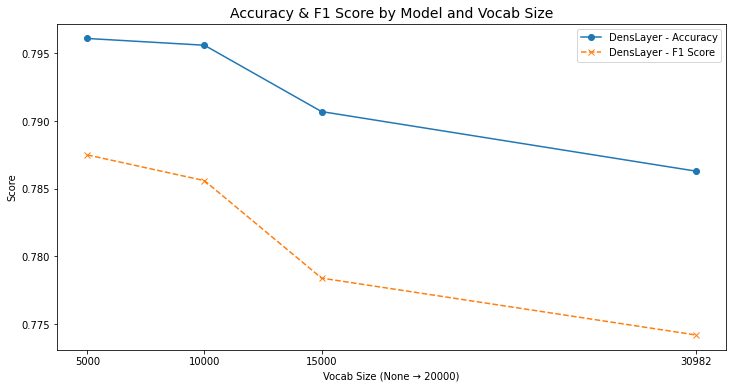

In [61]:
import pandas as pd
import matplotlib.pyplot as plt

# DataFrame 변환
df = pd.DataFrame(dl_results).sort_values(by="vocab_size")

# vocab_size가 None 또는 NaN인 경우 20000으로 치환
df['vocab_size_for_plot'] = df['vocab_size'].apply(
    lambda x: 20000 if pd.isna(x) else int(x)
)

# 그래프 그리기
#plt.style.use('seaborn-darkgrid')
fig, ax = plt.subplots(figsize=(12, 6))


# 모델별 plot
for model_name in df['model'].unique():
    model_df = df[df['model'] == model_name]
        
    ax.plot(model_df['vocab_size_for_plot'], model_df['val_accuracy'], 
            marker='o', label=f'{model_name} - Accuracy')
    ax.plot(model_df['vocab_size_for_plot'], model_df['f1_score'], 
            marker='x', linestyle='--', label=f'{model_name} - F1 Score')

# 레이블, 타이틀 등 설정
ax.set_title('Accuracy & F1 Score by Model and Vocab Size', fontsize=14)
ax.set_xlabel('Vocab Size )
ax.set_ylabel('Score')
ax.legend()
# x축 눈금 강제 지정
xticks = sorted(df['vocab_size_for_plot'].unique())
ax.set_xticks(xticks)

#plt.grid(True)
plt.show()

## 딥러닝 SimpleRNN 모델

In [8]:
from tensorflow import keras
from tensorflow.keras import layers

maxlen = 200           # 시퀀스 길이 고정

def build_rnn_model(input_dim, num_classes=46):
    model = keras.Sequential([
        layers.Embedding(input_dim=input_dim, output_dim=64, input_length=maxlen),
        layers.SimpleRNN(64),
        layers.Dense(num_classes, activation="softmax")
    ])

    model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"]
             )
    
    return model

In [11]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score #정확도 계산
from sklearn.metrics import classification_report



def RNN_Classifier( vocab_sizes ) :
   #for model in models: 
        rnn_results = []
        # 모델 이름 획득
        model_name = "SimpleRNN"
        
        
        for vocab_size in vocab_sizes:
            
            print(f"== ModelName: {model_name}, Vocab Size: {vocab_size}")
        
            (x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=vocab_size, test_split=0.2)
            
            # ✅ vocab_size가 None이면 디폴트 값으로 len(word_index) 사용
            vocab_dim = len(word_index) if vocab_size is None or pd.isna(vocab_size) else vocab_size
            
            # x_train 시퀀스 패딩
            x_train_vec = pad_sequences(x_train, maxlen=maxlen, padding='pre')
            x_test_vec = pad_sequences(x_test, maxlen=maxlen, padding='pre')
            
            # y : one-hot encoding
            y_train_vec = to_categorical(y_train, num_classes)
            y_test_vec = to_categorical(y_test, num_classes)
            
        
            if x_train_vec is not None and x_test_vec is not None:
                 
                es = EarlyStopping(monitor='loss', patience=3, verbose=1)
                
                model = build_rnn_model(vocab_dim)
                #훈련
                history = model.fit(x_train_vec, y_train_vec, 
                                    epochs =20, 
                                    batch_size=512,
                                    callbacks = es
                                    )
                               
                #테스트 데이터에 대한 예측
                predicted = model.predict(x_test_vec) 
                
                # 예측값에서 가장 확률이 높은 클래스 인덱스 추출
                predicted_labels = np.argmax(predicted, axis=1)
                # 원-핫 인코딩된 정답을 정수 라벨로 변환
                true_labels = np.argmax(y_test_vec, axis=1)
                
                #예측값과 실제값 비교
                accuracy =  accuracy_score(true_labels, predicted_labels)
                
                # 분류 성능 평가 (classification_report)
                cr = classification_report(true_labels, predicted_labels, zero_division=0, output_dict=True)
        
                print("   정확도:", round(accuracy, 5))
                print("   F1-Score:", round(cr['weighted avg']['f1-score'], 5))
        
        
                rnn_results.append({
                    'model': model_name, 
                    'vocab_size': vocab_size,
                    'val_accuracy': round(accuracy, 4),
                    'f1_score': round(cr['weighted avg']['f1-score'], 4)
                })


In [12]:
total_word_size = len(word_index) + 3
vocab_sizes = [total_word_size, 5000, 10000, 15000]

RNN_Classifier( vocab_sizes )

== ModelName: SimpleRNN, Vocab Size: 30982
Epoch 1/20
18/18 [==============================] - 6s 276ms/step - loss: 2.8432 - accuracy: 0.2975
Epoch 2/20
18/18 [==============================] - 5s 281ms/step - loss: 2.4201 - accuracy: 0.3517
Epoch 3/20
18/18 [==============================] - 5s 278ms/step - loss: 2.4013 - accuracy: 0.3516
Epoch 4/20
18/18 [==============================] - 5s 280ms/step - loss: 2.3842 - accuracy: 0.3706
Epoch 5/20
18/18 [==============================] - 5s 279ms/step - loss: 2.1740 - accuracy: 0.4545
Epoch 6/20
18/18 [==============================] - 5s 286ms/step - loss: 2.0377 - accuracy: 0.4771
Epoch 7/20
18/18 [==============================] - 5s 284ms/step - loss: 1.9165 - accuracy: 0.4987
Epoch 8/20
18/18 [==============================] - 5s 288ms/step - loss: 1.7905 - accuracy: 0.5335
Epoch 9/20
18/18 [==============================] - 5s 292ms/step - loss: 1.6375 - accuracy: 0.5807
Epoch 10/20
18/18 [==============================] - 5s 2

18/18 [==============================] - 5s 277ms/step - loss: 0.5534 - accuracy: 0.8910
Epoch 20/20
18/18 [==============================] - 5s 277ms/step - loss: 0.5111 - accuracy: 0.8981
   정확도: 0.49377
   F1-Score: 0.47733


In [13]:
# 결과 출력
for result in rnn_results:
    print(result)

NameError: name 'rnn_results' is not defined